In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CSE493sp25/Project/'
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CSE493sp25/Project


In [35]:
# dependencies
import tarfile
import time
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import requests
import os
from pathlib import Path
from PIL import Image
from io import BytesIO
from IPython.display import display
import plotly.express as px
import re
import aiohttp
# from deep_translator import GoogleTranslator
import asyncio
from bs4 import BeautifulSoup
import ssl
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [32]:
BASE_URL = "https://data.rijksmuseum.nl/search/collection"

# Use these wildcards to represent 1600s, 1700s, 1800s
centuries = ["16??", "17??", "18??"]
all_urls = []
max_per_century = 1000

def fetch_urls(creation_date, urls):
    url = f"{BASE_URL}?creationDate={creation_date}&type=painting"
    # do
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch {url} — status {response.status_code}")
        return
    data = response.json()
    total_items = int(data.get('partOf').get('totalItems'))
    pbar = tqdm(total=total_items, position=0, leave=True)
    start = len(urls)
    for item in data.get("orderedItems", []):
        urls.append(item.get("id"))
    pbar.update(len(urls) - start)
    next_pg = data.get("next", None)
    if next_pg:
        url = next_pg.get('id')
    while url and len(urls) < max_per_century:
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Failed to fetch {url} — status {response.status_code}")
            return
        data = response.json()
        # print(data)
        start = len(urls)
        for item in data.get("orderedItems", []):
            urls.append(item.get("id"))
        pbar.update(len(urls) - start)
        next_pg = data.get("next", None)
        if next_pg:
            url = next_pg.get('id')
    # print('next url', url)
    # print('total urls', len(urls))
    pbar.close()
    return urls

# Loop over all three centuries
for century in centuries:
    print('Fetching century', century)
    cur_urls = []
    fetch_urls(century, cur_urls)
    print(f"Found {len(cur_urls)} items for {century}")
    all_urls.extend(cur_urls)

# Store in a DataFrame
df = pd.DataFrame({"url": all_urls})
print(f"Total collected URLs: {len(df)}")
df.to_csv('rijksurls.csv')

Fetching century 16??


1020it [00:03, 271.78it/s]


Found 1020 items for 16??
Fetching century 17??


1036it [00:04, 255.96it/s]


Found 1036 items for 17??
Fetching century 18??


1044it [00:04, 252.84it/s]

Found 1044 items for 18??
Total collected URLs: 3100


In [33]:
df.head()

,url
0,https://id.rijksmuseum.nl/200702560
1,https://id.rijksmuseum.nl/200695108
2,https://id.rijksmuseum.nl/20079263
3,https://id.rijksmuseum.nl/200586378
4,https://id.rijksmuseum.nl/200765122


In [69]:
def get_rijks_data(rijks_url):
    try:
        r = requests.get(rijks_url)
        data = r.json()

        # ------------------------
        # 1. Image URL
        # Get DigitalObject ID
        digital_obj_id = None
        for shown in data.get("shows", []):
            for dig in shown.get("digitally_shown_by", []):
                if "id" in dig and dig["id"].startswith("http"):
                    digital_obj_id = dig["id"]
                    break

        # Resolve DigitalObject to get image URL
        image_url = None
        if digital_obj_id:
            r2 = requests.get(digital_obj_id)
            if r2.ok:
                digital_data = r2.json()
                image_url = digital_data.get("access_point")[0].get('id')
                if not image_url and "content" in digital_data:
                    image_url = digital_data["content"]

        # ------------------------
        # 2. Date range (e.g., 1613)
        date_range = None
        if "produced_by" in data:
            timespan = data["produced_by"].get("timespan", {})
            # Use named year if available
            start_year = timespan.get('begin_of_the_begin')[:4]
            end_year = timespan.get('end_of_the_end')[:4]
            if start_year.isdigit() and end_year.isdigit():
              start_year = int(start_year)
              end_year = int(end_year)
              year = (start_year + end_year) // 2
            else:
              start_year, end_year, year = None, None, None

        # ------------------------
        # 3. Form of art
        form = None
        for item in data.get("subject_of", []):
            if isinstance(item, dict):
                content = item.get("content", "")
                if "painting" in content.lower():
                    form = "Painting"
                    break
        # fallback from "classified_as"
        if not form and "classified_as" in data:
            form = data["classified_as"][0].get("id")

        return {
            "URL": image_url,
            "Start Date": start_year,
            "End Date": end_year,
            "Year": year,
            # "Form": form
        }

    except Exception as e:
        print(f"Error processing {rijks_url}: {e}")
        return {
            "URL": None,
            "Start Date": None,
            "End Date": None,
            "Year": None,
            # "Form": None
        }

In [80]:
new_cols = []
for row in tqdm(df['url']):
  new_cols.append(get_rijks_data(row))
  new_cols[-1]['rijksurl'] = row

rijks_df = pd.DataFrame(new_cols)
rijks_df.head()

 14%|█▍        | 428/3100 [12:35<14:28:18, 19.50s/it]

Error processing https://id.rijksmuseum.nl/200108147: 'list' object has no attribute 'get'


 37%|███▋      | 1161/3100 [33:31<40:40,  1.26s/it]

Error processing https://id.rijksmuseum.nl/200116890: 'list' object has no attribute 'get'


 70%|███████   | 2185/3100 [1:03:47<21:18,  1.40s/it]

Error processing https://id.rijksmuseum.nl/200108317: 'list' object has no attribute 'get'


 73%|███████▎  | 2273/3100 [1:05:56<19:39,  1.43s/it]

Error processing https://id.rijksmuseum.nl/20025850: 'list' object has no attribute 'get'


100%|██████████| 3100/3100 [1:28:34<00:00,  1.71s/it]


,URL,Start Date,End Date,Year,Form,rijksurl
0,None,1671.0,1671.0,1671.0,https://id.rijksmuseum.nl/2208,https://id.rijksmuseum.nl/200702560
1,https://iiif.micr.io/jMCNh/full/max/0/default.jpg,1688.0,1688.0,1688.0,https://id.rijksmuseum.nl/2208,https://id.rijksmuseum.nl/200695108
2,https://iiif.micr.io/cCvFm/full/max/0/default.jpg,1682.0,1682.0,1682.0,https://id.rijksmuseum.nl/2208,https://id.rijksmuseum.nl/20079263
3,https://iiif.micr.io/TDdUO/full/max/0/default.jpg,1676.0,1676.0,1676.0,https://id.rijksmuseum.nl/2208,https://id.rijksmuseum.nl/200586378
4,https://iiif.micr.io/dQNot/full/max/0/default.jpg,1613.0,1613.0,1613.0,https://id.rijksmuseum.nl/2208,https://id.rijksmuseum.nl/200765122


In [83]:
print(len(rijks_df))
rijks_df = rijks_df.dropna(subset=['URL'])
print(len(rijks_df))

3100
2935


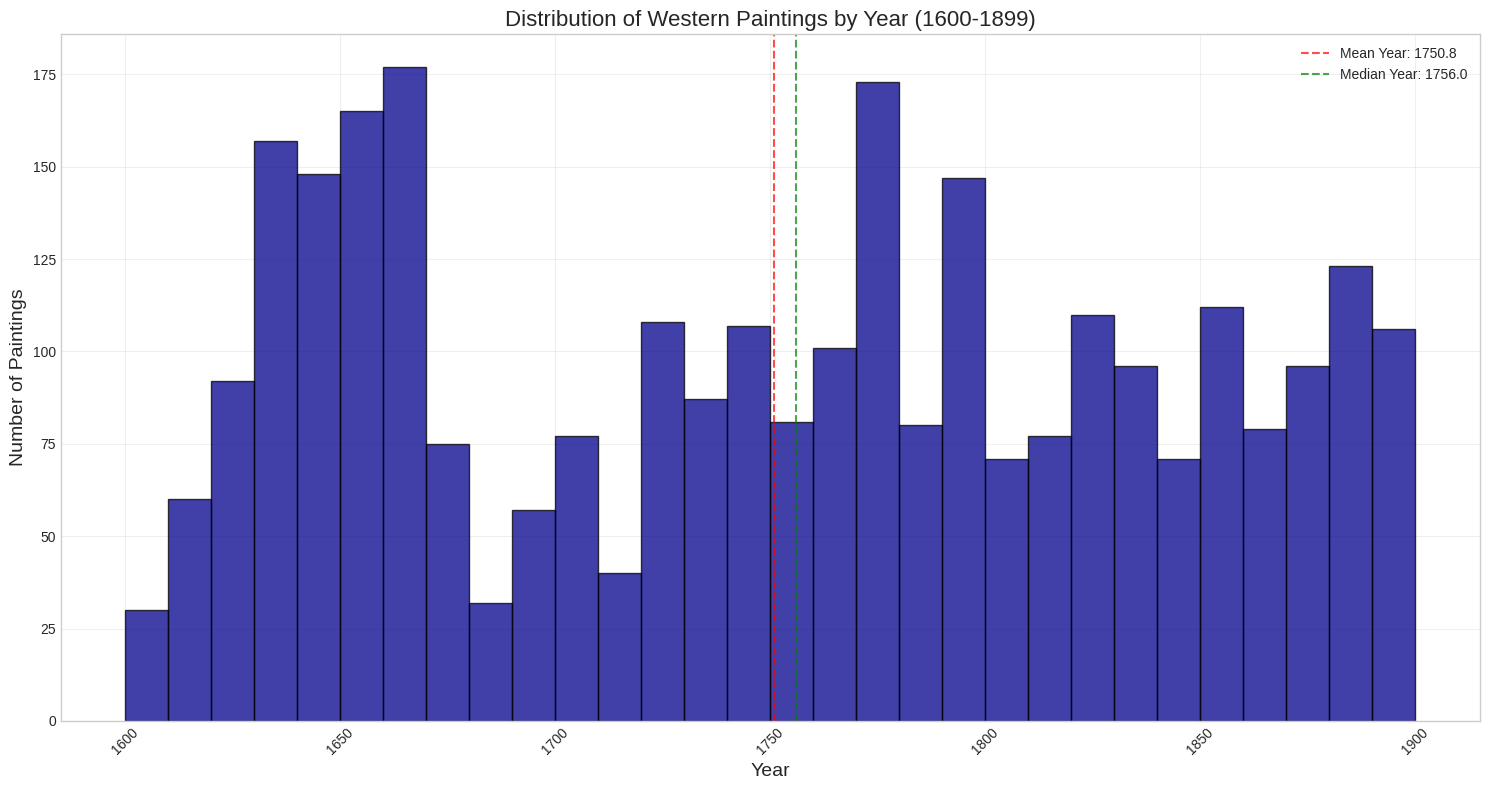

In [85]:
def show_decades(df):
  '''
    Plots the decades of paintings in the dataframe. Every row must have a value in the 'Year' column
  '''
  # Set the style for better visualization
  plt.style.use('seaborn-v0_8-whitegrid')
  sns.set_palette("deep")

  # Create the histogram
  plt.figure(figsize=(15, 8))

  # Create the histogram with custom bins (10-year intervals)
  bins = np.arange(1600, 1901, 10)  # From 1600 to 1900 in steps of 10
  plt.hist(df['Year'], bins=bins, alpha=0.75,
          color='darkblue', edgecolor='black')

  # Add a title and labels
  plt.title('Distribution of Western Paintings by Year (1600-1899)', fontsize=16)
  plt.xlabel('Year', fontsize=14)
  plt.ylabel('Number of Paintings', fontsize=14)

  # Add a grid for better readability
  plt.grid(True, alpha=0.3)

  # Make x-axis labels more readable by rotating them and showing fewer labels
  plt.xticks(bins[::5], rotation=45)  # Show every 5th bin label (50-year intervals)

  # Add context with text annotations
  avg_year = df['Year'].mean()
  median_year = df['Year'].median()
  plt.axvline(x=avg_year, color='red', linestyle='--', alpha=0.7,
              label=f'Mean Year: {avg_year:.1f}')
  plt.axvline(x=median_year, color='green', linestyle='--', alpha=0.7,
              label=f'Median Year: {median_year:.1f}')

  # Add a legend
  plt.legend()

  # Improve layout
  plt.tight_layout()
  plt.show()

show_decades(rijks_df)

In [86]:
def preview_images(rows, link_processor=lambda x: x):
  '''
    Expects a 'Link' and a 'Year' column. The link should go directly to the image.
    The link_processor will be applied to the 'URL' columns before fetching
  '''
  # print(rows)
  n_rows = 1
  n_cols = len(rows)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
  axes = axes.flatten()
  size = 128

  for (i, row), ax in zip(rows.iterrows(), axes):
      # print(row)
      # print(f"Title: {row['Artwork']} | Artist: {row['Artist']}")
      try:
          url = link_processor(row['URL'])
          response = requests.get(url)
          img = Image.open(BytesIO(response.content))
          h, w = img.size
          long_dim = max(h, w)
          ratio = long_dim // size
          # print(h, w, ratio)
          img_resized = (h // ratio, w // ratio)
          img = img.resize(img_resized)
          ax.imshow(img)
          ax.axis('off')
          ax.set_title(f"Year: {row['Year']}")
      except Exception as e:
          print(f"Failed to load image from {link_processor(row['URL'])}: {e}")
          ax.text(0.5, 0.5, 'Error', ha='center', va='center')
          ax.axis('off')

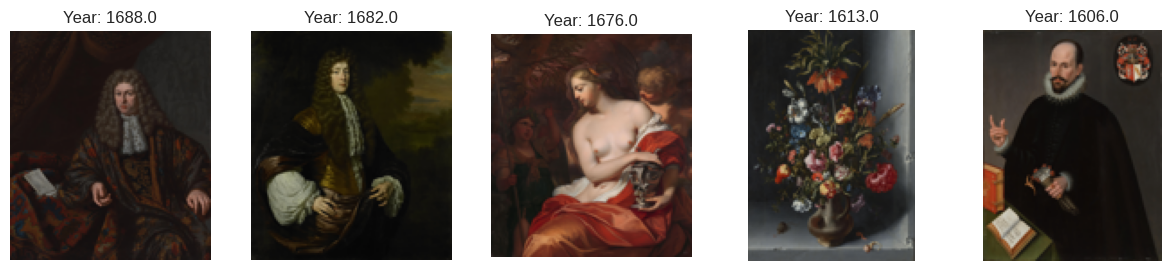

In [87]:
preview_images(rijks_df.head())

In [88]:
rijks_df.to_csv('rijks data 3000.csv')